In [85]:
# std libraries
import csv
import re
import ssl
# data science libraries 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# nlp libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# sklearning ml libraries 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# SSL for nltk downloads
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [86]:
#create label to classification relations

#true, mostly-true, half-true, barely-true, false, pants-fire
true_labels = ['true', 'mostly-true']
false_labels = ['false', 'pants-fire']

#create map for each label and it's class (0/1)
label_mapping = {label: 1 for label in true_labels}
label_mapping.update({label: 0 for label in false_labels})

In [87]:
# Read in the training dataset
#tsv structure: statement: with properties => label, claim, (add 'class' column at the end)

#each row is called a claim
col_dict = {
    "id": 0, 
    "label": 1, 
    "statement": 2, 
    "subject": 3, 
    "speaker": 4,
    "speaker_job_title": 5,
    "state": 6,
    "party_affiliation": 7, 
    "barely_true_counts": 8,
    "false_counts": 9,
    "half_true_counts": 10,
    "mostly_true_counts": 11, 
    "pants_on_fire_counts": 12,
    "context": 13
}

column_names = ["label", "statement", 'subject', 'speaker', 'speaker_job_title', 'party_affiliation', 'context']
usecols = [col_dict[key] for key in column_names]

train_df = pd.read_csv("../train.tsv", sep="\t", header=None, names=column_names, usecols=usecols, quoting=csv.QUOTE_NONE)
test_df = pd.read_csv("../test.tsv", sep="\t", header=None, names=column_names, usecols=usecols, quoting=csv.QUOTE_NONE)


In [88]:
# create new column with 'class' being either 0/1 based on the label
# we'll also drop any claim row that doesn't have one of the labels we're looking at
def fixDataFrame(df, label_mapping):
    df['class'] = df['label'].str.strip().str.lower().map(label_mapping)
    return df.dropna(subset=['class'])
def checkDF(df):
    print("Sample of data entries:")
    print(df.sample(5, random_state=0))
    print(f"Total Entries: {len(df)}")

    counts = df['class'].value_counts()
    print(f"Count of 0's: {counts.get(0, 0)}")
    print(f"Count of 1's: {counts.get(1, 0)}")

train_df = fixDataFrame(train_df, label_mapping)
test_df = fixDataFrame(test_df, label_mapping)

In [89]:
# Print label distribution
print("Training label dist:")
print(train_df['label'].value_counts())
print()
# Create True and Fake media claims Data Frame
true_df = train_df[train_df['label'].isin(true_labels)]
fake_df = train_df[train_df['label'].isin(false_labels)]
print(f"True Claims Being Used: {len(true_df)}")
print(f"Fake Articles Being Used: {len(fake_df)}")


Training label dist:
label
false          1998
mostly-true    1966
true           1683
pants-fire      842
Name: count, dtype: int64

True Claims Being Used: 3649
Fake Articles Being Used: 2840


In [90]:
# max possible claims that can be used to train false and true 
# Balance the training dataset (50/50)
maxClaims = min(len(fake_df), len(true_df))
true_df = true_df.sample(maxClaims, random_state=10)
false_df = false_df.sample(maxClaims, random_state=10)
balanced_train_df = pd.concat([true_df, false_df]).sample(frac=1, random_state=42).reset_index(drop=True)

print("\nBalanced training label dist:")
print(balanced_train_df['class'].value_counts().rename({0: "Fake", 1: "Real"}))


Balanced training label dist:
class
Real    2840
Fake    2840
Name: count, dtype: int64


In [91]:
# Testing Label DataFrame

print("\nTest label dist:")
print(test_df['label'].value_counts())
test_true_count = len(test_df[test_df['label'].isin(true_labels)])
test_fake_count = len(test_df[test_df['label'].isin(false_labels)])
print(f"\nTest dataset: {test_true_count} true articles, {test_fake_count} fake articles")


Test label dist:
label
false          250
mostly-true    249
true           211
pants-fire      92
Name: count, dtype: int64

Test dataset: 460 true articles, 342 fake articles


In [92]:
# Preprocessing, create new column 'clean_text'
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', str(text)).lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

balanced_train_df['clean_text'] = balanced_train_df['statement'].apply(preprocess_text)
test_df['clean_text'] = test_df['statement'].apply(preprocess_text)


Naive Bayes:
Accuracy: 0.6309
Classification Report:
               precision    recall  f1-score   support

         0.0       0.57      0.58      0.57       342
         1.0       0.68      0.67      0.68       460

    accuracy                           0.63       802
   macro avg       0.62      0.62      0.62       802
weighted avg       0.63      0.63      0.63       802

Logistic Regression:
Accuracy: 0.6172
Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.61      0.58       342
         1.0       0.68      0.62      0.65       460

    accuracy                           0.62       802
   macro avg       0.61      0.62      0.61       802
weighted avg       0.62      0.62      0.62       802

SVC:
Accuracy: 0.5848
Classification Report:
               precision    recall  f1-score   support

         0.0       0.51      0.58      0.54       342
         1.0       0.65      0.59      0.62       460

    accuracy       

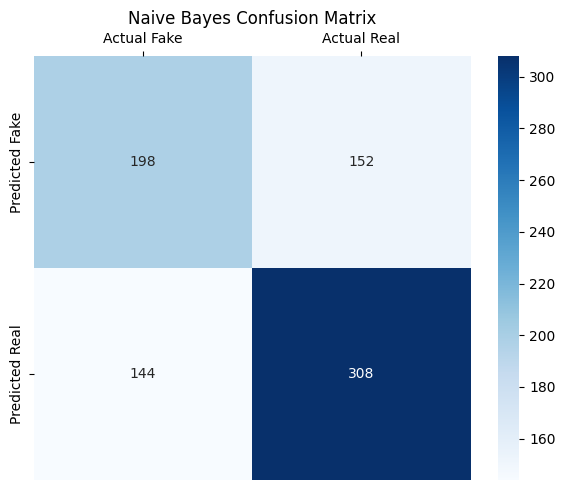

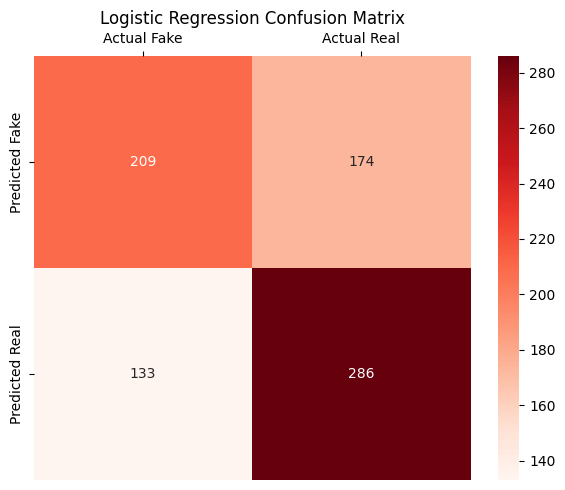

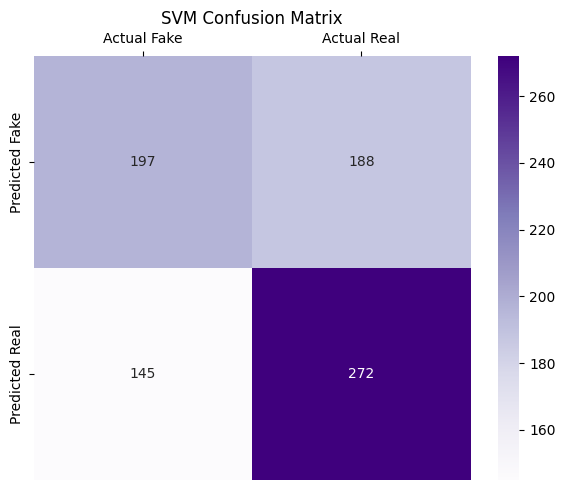

In [93]:
# Vectorization
vectorizer = CountVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(balanced_train_df['clean_text'])
y_train = balanced_train_df['class']
X_test = vectorizer.transform(test_df['clean_text'])
y_test = test_df['class']

# Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nNaive Bayes:")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
log_pred = log_reg.predict(X_test)
log_accuracy = accuracy_score(y_test, log_pred)
print("Logistic Regression:")
print(f"Accuracy: {log_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, log_pred))

# SVM
svm = LinearSVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVC:")
print(f"Accuracy: {svm_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, svm_pred))

# Confusion matrices
nb_cm = confusion_matrix(y_test, y_pred)
cm_logreg = confusion_matrix(y_test, log_pred)
cm_svm = confusion_matrix(y_test, svm_pred)

# Define the confusion matrices and titles

#transpose confusion matrices to get it in right orientation given sns heatmap being used
cms = [nb_cm.T, cm_logreg.T, cm_svm.T]
titles = ['Naive Bayes Confusion Matrix', 'Logistic Regression Confusion Matrix', 'SVM Confusion Matrix']
cmaps = ['Blues', 'Reds', 'Purples']

# Plot heatmaps
figsize = (6, 5)

for cm, title, cmap in zip(cms, titles, cmaps):
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                yticklabels=["Predicted Fake", "Predicted Real"],
                xticklabels=["Actual Fake", "Actual Real"])
    plt.title(title)
    plt.gca().xaxis.set_label_position('top') 
    plt.gca().xaxis.tick_top()
    plt.tight_layout()
    plt.show()